# Blazar outburst ([HB89] 1352-104, EPIC 212595811)

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob
import lightkurve as lk

In [2]:
def ThrustObjectMask(data,thrust):
    """
    Creates a sceince target mask through standard deviation cuts on an average of stable frames. 
    To avoid masking out an event, a comparison of two masks, at the begining and end of the campaign are used.
    Points that appear in both masks are used in the final mask.
    This method has issues when the pointing completely breaks down during the campaign, such as in C10.
    """
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask

In [3]:
file = '/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo212595811-c06_lpd-targ.fits.gz'
tpf = lk.KeplerTargetPixelFile(file)

In [11]:
hdu = fits.open(file)
flux = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data

Qual = hdu[1].data.field('QUALITY')
thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]

dat = hdu[1].data
xdrif = dat['pos_corr1']
ydrif = dat['pos_corr2']

distdrif = np.sqrt(xdrif**2 + ydrif**2)
goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
Mask = ThrustObjectMask(flux,goodthrust)
obj = np.ma.masked_invalid(Mask).mask

lc = np.nansum(tpf.flux*obj,axis=(1,2))

/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater_equal
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in less
/Users/ryanr/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater_equal


In [12]:
LC = np.zeros((len(tpf.time),2))
LC[:,0] = tpf.astropy_time.mjd
LC[:,1] =lc

In [15]:
np.savetxt('212595811_lc.txt',LC)

In [6]:
2454833+2384

2457217

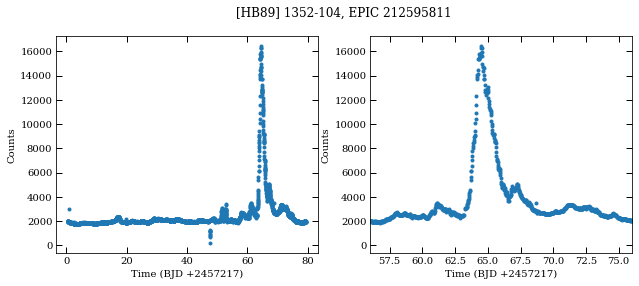

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tpf.time-2384,lc,'.')
plt.ylabel('Counts')
plt.xlabel('Time (BJD +{})'.format(2457217))

plt.subplot(1,2,2)
plt.plot(tpf.time-2384,lc,'.')
plt.ylabel('Counts')
plt.xlabel('Time (BJD +{})'.format(2457217))
plt.xlim(2440-2384,2460-2384)
#plt.tight_layout()
plt.suptitle('[HB89] 1352-104, EPIC 212595811')
plt.savefig('blazar_outburst.pdf')

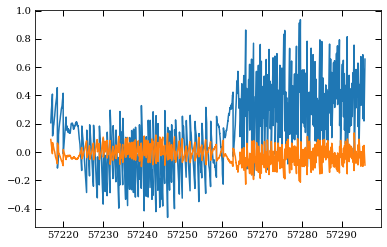

In [19]:
distance = np.sqrt(tpf.pos_corr1**2 + tpf.pos_corr2**2)
plt.figure()
plt.plot(tpf.astropy_time.mjd[distance < 2],tpf.pos_corr1[distance < 2])
plt.plot(tpf.astropy_time.mjd[distance < 2],tpf.pos_corr2[distance < 2])

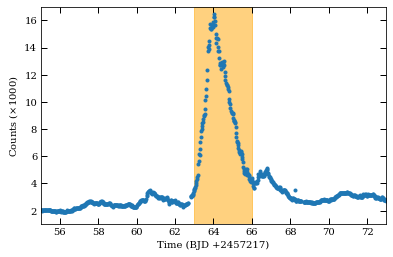

In [44]:
plt.figure(figsize=(6,4))
plt.axvspan(63,66,color='orange',alpha=0.5)
#plt.plot(tpf.time,-2.5*np.log10(lc)+25.47,'.')
plt.plot(tpf.time-tpf.time[0],lc/1000,'.')

plt.ylabel(r'Counts $(\times 1000)$')
plt.xlabel('Time (BJD +{})'.format(2454833 + int(tpf.time[0])))
plt.xlim(55,73)
plt.ylim(1,17)
#plt.ylim(17.4,14.6)
plt.savefig('blaze_outburst_mag.pdf')

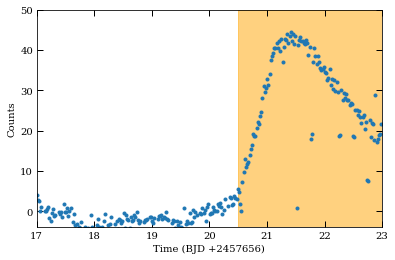

In [40]:
lc = np.load('../unkown_lc.npy')
plt.figure(figsize=(6,4))
plt.axvspan(20.5,23,color='orange',alpha=0.5)
plt.plot(lc[0,:]-lc[0,0],lc[1,:],'.')

plt.ylim(-4,50)
plt.xlim(17,23)

plt.ylabel(r'Counts')
plt.xlabel('Time (BJD +{})'.format(int(lc[0,0])))
plt.savefig('unkown_c11.pdf')

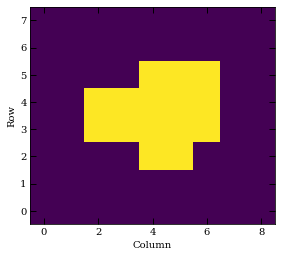

In [21]:
plt.figure()
plt.imshow(obj,origin='lower')
plt.ylabel('Row')
plt.xlabel('Column')
plt.savefig('aperture_mask.png')